<a href="https://colab.research.google.com/github/mthomp24/Final-Coding-Challenge/blob/master/FCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

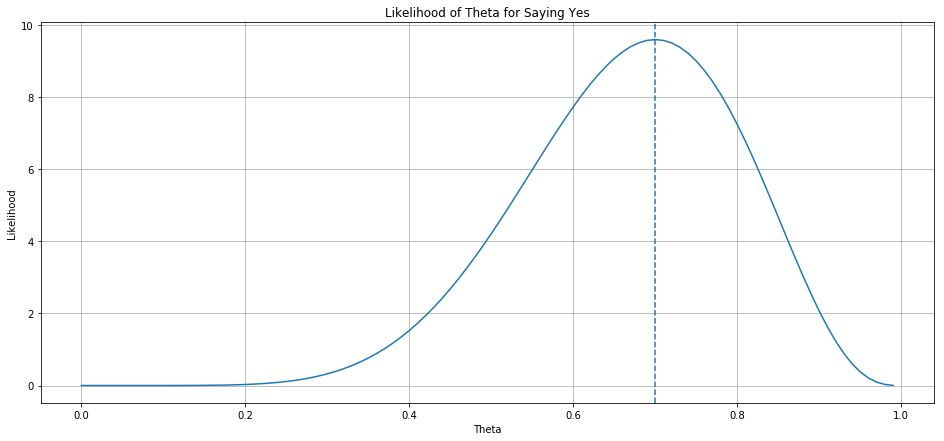

The maximum theta for the liklihood function is 0.7


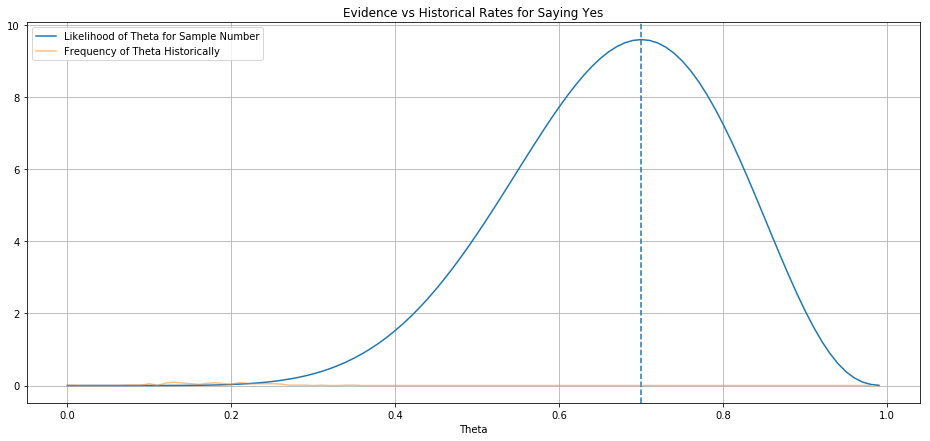

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


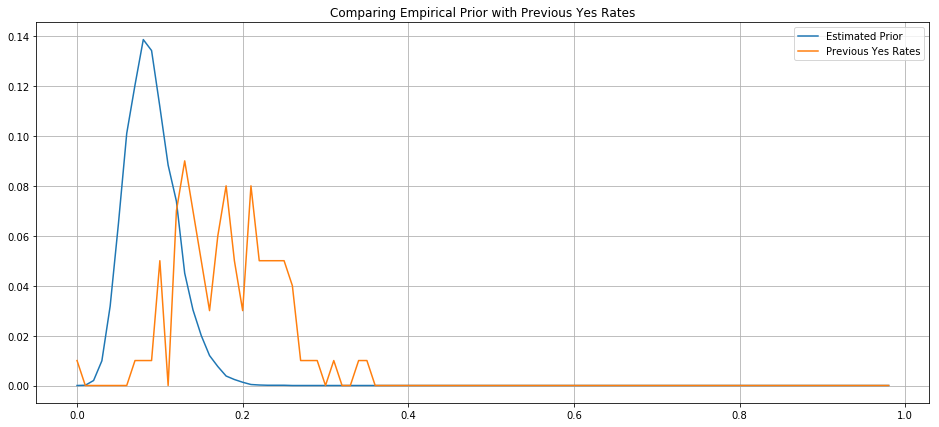

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -5,102.8, ||grad|| = 355.93: 100%|██████████| 6/6 [00:00<00:00, 564.62it/s]
Sequential sampling (2 chains in 1 job)
NUTS: [prior]
100%|██████████| 5500/5500 [00:02<00:00, 1960.34it/s]


The mean of the most plausible theta is  0.19246848156420526


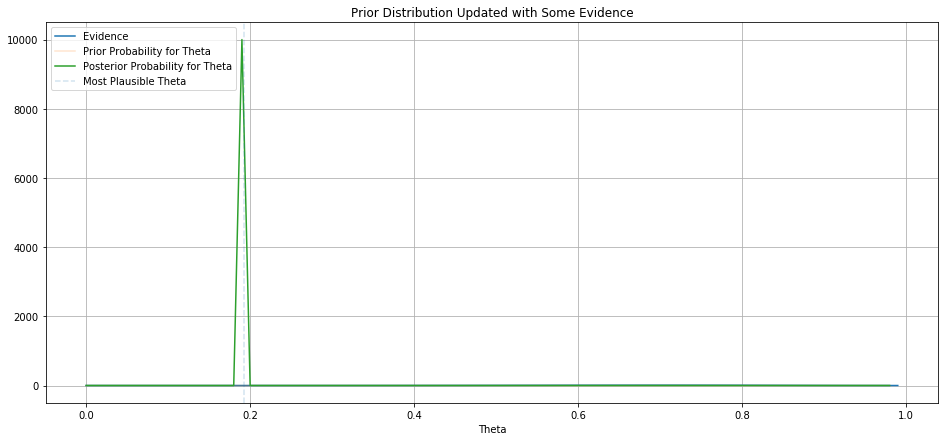

In [10]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.special import factorial

# The question that is being evaluated is that if 10 people were asked if they liked corgis and 7 of them said yes what is the probability that the next person asked would say yes.

def liklihood(theta,n,x):
  # liklihood function for a binomial distribution
  # x is the number of successes 
  # n is the number of experiments
  
  return (factorial(n)/ factorial(x) * factorial(n-x)) * (theta**x) * ((1-theta)**(n-x))

# sample number 

sample_num = 10
n = 10
# number of people who said yes

num_yes = 7
x = 7
# observed probability of saying yes

obs_prob = num_yes / sample_num

# all possible observed probabilities
possible_theta_values = list(map(lambda x: x/100,range(100)))

# Evaluate liklihood function for observed probability

liklihoods = list(map(lambda theta: liklihood(theta,n,x), possible_theta_values))

# Find the most likely estimate(MLE) of theta

mle = possible_theta_values[np.argmax(liklihoods)]

# Plot the Liklihood function

f, ax = plt.subplots(1)
ax.plot(possible_theta_values, liklihoods)
ax.axvline(mle, linestyle = "--")
ax.set_xlabel("Theta")
ax.set_ylabel("Likelihood")
ax.grid()
ax.set_title("Likelihood of Theta for Saying Yes")
plt.show()

# Max liklihood theta
max_height = np.argmax(liklihoods)
max_theta = possible_theta_values[max_height]
print('The maximum theta for the liklihood function is', max_theta)

#Distribution of observed probability rate

true_a = 11.5
true_b = 48.5
#number of samples
N = 100    #randomly generate "true" observed probability
p = np.random.beta(true_a,true_b, size=N)
#randomly pick the number of times people say yes
impressions = np.random.randint(1, 10000, size=N)
#sample number of clicks for each campaign
yeses = np.random.binomial(impressions, p).astype(float)
previous_yes_rates = liklihoods
yes_rates = yeses / impressions
#plot the histogram of previous yes rates with the evidence of the sample number
f, ax = plt.subplots(1)
ax.axvline(mle, linestyle = "--")
ax.plot(possible_theta_values, liklihoods)

zero_to_one = [j/100. for j in range(100)]
counts, bins = np.histogram(yes_rates, bins=zero_to_one)
counts = counts / 100.
ax.plot(bins[:-1],counts, alpha = .5)
line1, line2, line3 = ax.lines
ax.legend((line2, line3), ('Likelihood of Theta for Sample Number', 'Frequency of Theta Historically'), loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid()
ax.set_title("Evidence vs Historical Rates for Saying Yes")
plt.show()


#Prior Distribution

from scipy.stats import beta

#fit beta to previous CTRs
prior_parameters = beta.fit(yes_rates, loc = 0, scale = 1)   #extract a,b from fit
prior_a, prior_b = prior_parameters[0:2]

#define prior distribution sample from prior
prior_distribution = beta(prior_a, prior_b)

#get histogram of samples
prior_samples = prior_distribution.rvs(10000)

#get histogram of samples
fit_counts, bins = np.histogram(prior_samples, zero_to_one)    #normalize histogram
fit_counts = list(map(lambda x: float(x)/fit_counts.sum(), fit_counts))

#plot emperical prior values with previous yes rates
f, ax = plt.subplots(1)
ax.plot(bins[:-1], fit_counts)

hist_ctr, bins = np.histogram(yes_rates, zero_to_one)
hist_ctr = list(map(lambda x: float(x)/hist_ctr.sum(), hist_ctr))
ax.plot(bins[:-1], hist_ctr)
estimated_prior, previous_yes_rates = ax.lines
ax.legend((estimated_prior, previous_yes_rates),('Estimated Prior', 'Previous Yes Rates'))
ax.grid()
ax.set_title("Comparing Empirical Prior with Previous Yes Rates")
plt.show()




#Posterior Distribution
import pymc3 as pm
import numpy as np

#create our data:clicks = np.array([n_clicks])
#yeses represents our successes. We observed 7 yesess.impressions = np.array([n_impressions])
#This represents the number of trials. There were 10 impressions.

with pm.Model() as model:
#sets a context; all code in block "belongs" to the model object

    theta_prior = pm.Beta('prior', 11.5, 48.5)
    #our prior distribution, Beta (11.5, 48.5)
    observations = pm.Binomial('obs',n = impressions, p = theta_prior, observed = yeses)     #Sampling distribition of outcomes in the dataset.
    #our prior p_prior will be updated with data


    start = pm.find_MAP()    #find good starting values for the sampling algorithm
    #Max Aposterior values, or values that are most likely

    step = pm.NUTS()   

    trace = pm.sample(5000, step, start=start, progressbar=True)               #obtain samples
    
    

# Find most probable theta with prior distribution and the evidence

#plot the histogram of yes rates
plt.rcParams['figure.figsize'] = (16, 7)

#get histogram of samples from posterior distribution of CTRs
posterior_counts, posterior_bins = np.histogram(trace['prior'],bins=zero_to_one)
#normalized histogramposterior_counts = posterior_counts / float(posterior_counts.sum())

#take the mean of the samples as most plausible value
most_plausible_theta = np.mean(trace['prior'])
print('The mean of the most plausible theta is ', most_plausible_theta)

#histogram of samples from prior distribution
prior_counts, bins = np.histogram(prior_samples, zero_to_one)#normalize
prior_counts = list(map(lambda x: float(x)/prior_counts.sum(), prior_counts))

#plot prior distribution and evidence
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, liklihoods)
ax.plot(bins[:-1],prior_counts, alpha = .2)
ax.plot(bins[:-1],posterior_counts)
ax.axvline(most_plausible_theta, linestyle = "--", alpha = .2)
line1, line2, line3, line4 = ax.lines
ax.legend((line1, line2, line3, line4), ('Evidence', 'Prior Probability for Theta', 'Posterior Probability for Theta', 'Most Plausible Theta'), loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid()
ax.set_title("Prior Distribution Updated with Some Evidence")
plt.show()

